#Libraries

In [1]:
# Uninstall any conflicting installations
!pip uninstall -y cupy cupy-cuda11x cupy-cuda12x cuml cudf

# Install CuPy for CUDA 12.x
!pip install cupy-cuda12x

# Install RAPIDS libraries for CUDA 12.x
!pip install cuml-cu12 cudf-cu12

# Fix missing libcublas library if needed
!apt-get update
!apt-get install -y libcublas-12-0


Found existing installation: cupy-cuda12x 12.2.0
Uninstalling cupy-cuda12x-12.2.0:
  Successfully uninstalled cupy-cuda12x-12.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 MB 20.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... 

In [2]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import cupy as cp
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


#Data

In [3]:
data = joblib.load('/content/drive/MyDrive/Bankruptcy Prediction Data/Prepared Dataset for Thesis/Dataset.pkl')
print(data.head())

X = data.drop(columns=['result'])
y = data['result']

   Profitability Ratios (Return from Sales) EBIT/Sales last avail. Year  \
0                                           1.281861                      
1                                           0.022043                      
2                                           3.210585                      
3                                          51.385155                      
4                                          37.085847                      

   Profitability Ratios (Return from Sales) EBIT/Sales last year -1  \
0                                          -0.073507                  
1                                          -0.027587                  
2                                          -2.198620                  
3                                          -2.196863                  
4                                          -2.354131                  

   Profitability Ratios (Return from Sales) EBIT/Sales last year -2  \
0                                           0.03703

In [4]:
data.shape

(255919, 61)

In [5]:

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Def

In [12]:
import numpy as np
import cupy as cp
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


class NaiveBayesKDE(BaseEstimator, ClassifierMixin):
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth
        self.kde_models = {}
        self.class_priors = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.kde_models = {label: [] for label in self.classes_}
        self.class_priors = {label: np.log((y == label).mean()) for label in self.classes_}

        # Convert data to GPU
        X_gpu = cp.array(X)
        y_gpu = cp.array(y)

        for label in self.classes_:
            X_class = X_gpu[y_gpu == label]
            for feature in range(X.shape[1]):
                kde = GPUKernelDensityEstimator(bandwidth=self.bandwidth)
                kde.fit(X_class[:, feature].reshape(-1, 1))
                self.kde_models[label].append(kde)
        return self

    def _calculate_log_likelihood(self, X, label, batch_size=100):
        X_gpu = cp.array(X)
        log_likelihood = 0
        for feature_idx, kde in enumerate(self.kde_models[label]):
            feature_column = X_gpu[:, feature_idx].reshape(-1, 1)
            log_likelihood += kde.score_samples(feature_column, batch_size=batch_size)
        return log_likelihood

    def predict(self, X, batch_size=100):
        X_gpu = cp.array(X)
        log_probs = []
        for label in self.classes_:
            log_likelihood = self._calculate_log_likelihood(X_gpu, label, batch_size=batch_size)
            log_prob = log_likelihood + self.class_priors[label]
            log_probs.append(log_prob)
        log_probs = cp.stack(log_probs, axis=1)
        return cp.asnumpy(cp.argmax(log_probs, axis=1))

    def predict_proba(self, X, batch_size=100):
        X_gpu = cp.array(X)
        log_probs = []
        for label in self.classes_:
            log_likelihood = self._calculate_log_likelihood(X_gpu, label, batch_size=batch_size)
            log_prob = log_likelihood + self.class_priors[label]
            log_probs.append(log_prob)
        log_probs = cp.stack(log_probs, axis=1)

        # Safeguard against numerical instability
        max_log_probs = cp.max(log_probs, axis=1, keepdims=True)
        log_probs = log_probs - max_log_probs
        probs = cp.exp(log_probs)
        probs /= cp.sum(probs, axis=1, keepdims=True)
        return cp.asnumpy(probs)


class GPUKernelDensityEstimator:
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth
        self.data = None

    def fit(self, X):
        self.data = cp.array(X)

    def score_samples(self, X, batch_size=100):
        if X.ndim == 1:
            X = X[:, cp.newaxis]  # Ensure X is 2D

        n_samples = X.shape[0]
        n_data = self.data.shape[0]
        bandwidth_squared = self.bandwidth ** 2

        densities = []
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch = X[start:end]
            distances = cp.sum((batch[:, cp.newaxis, :] - self.data[cp.newaxis, :, :]) ** 2, axis=2)
            kernel_values = cp.exp(-distances / (2 * bandwidth_squared))
            batch_densities = cp.sum(kernel_values, axis=1) / (n_data * cp.sqrt(2 * cp.pi * bandwidth_squared))
            densities.append(batch_densities)

        densities = cp.concatenate(densities, axis=0)
        densities = cp.maximum(densities, 1e-10)  # Avoid log(0)
        return cp.log(densities)

In [13]:
models = {    "Naive Bayes": NaiveBayesKDE(bandwidth=1.0) }

#Cross Validation

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
cv_results = {model_name: [] for model_name in models.keys()}
roc_curves_cv = {model_name: [] for model_name in models.keys()}
pr_curves_cv = {model_name: [] for model_name in models.keys()}

#Fitting models and Evaluations

Training Naive Bayes with Cross-Validation
Mean Threshold for Naive Bayes: 0.97

Cross-validation Metrics for Naive Bayes:
  Fold 1:
    Accuracy: 0.8814
    Precision: 0.4746
    Recall: 0.6576
    F1: 0.5513
    ROC AUC: 0.8949
    PR AUC: 0.5573
    Class Accuracies: {'non_bankrupt': 0.9092547020566004, 'bankrupt': 0.6576163610719323}
  Fold 2:
    Accuracy: 0.8967
    Precision: 0.5323
    Recall: 0.5575
    F1: 0.5446
    ROC AUC: 0.8941
    PR AUC: 0.5553
    Class Accuracies: {'non_bankrupt': 0.9389611531024785, 'bankrupt': 0.557475317348378}
  Fold 3:
    Accuracy: 0.8890
    Precision: 0.4992
    Recall: 0.5843
    F1: 0.5384
    ROC AUC: 0.8868
    PR AUC: 0.5338
    Class Accuracies: {'non_bankrupt': 0.9269643171031816, 'bankrupt': 0.5842736248236954}
  Fold 4:
    Accuracy: 0.8927
    Precision: 0.5130
    Recall: 0.6181
    F1: 0.5607
    ROC AUC: 0.8982
    PR AUC: 0.5611
    Class Accuracies: {'non_bankrupt': 0.9268764281947618, 'bankrupt': 0.6181241184767278}
  Fold 5:


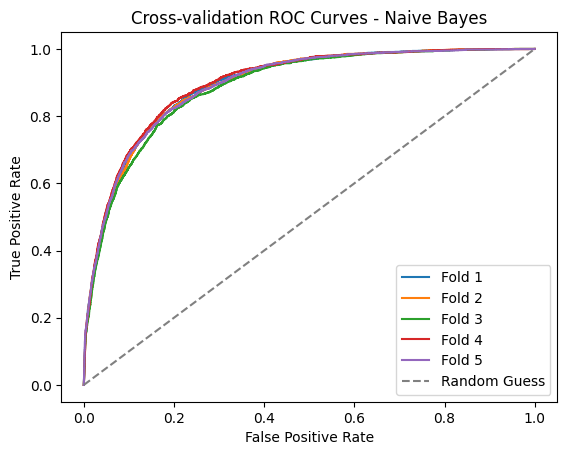

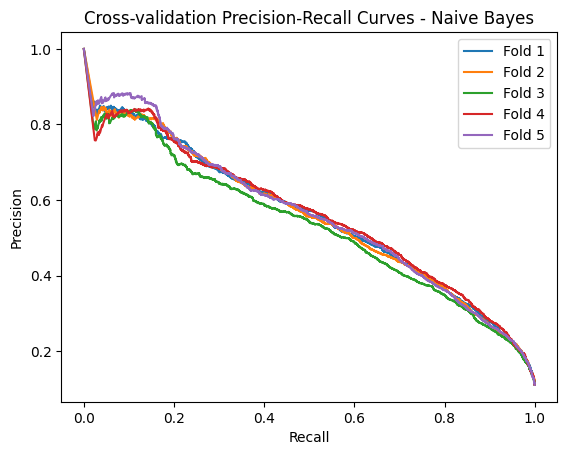


Final Training for Naive Bayes

Final Metrics for Naive Bayes:
  Accuracy: 0.8880
  Precision: 0.4957
  Recall: 0.6298
  F1 Score: 0.5548
  ROC AUC: 0.8966
  PR AUC: 0.5603
  Class Accuracies: {'non_bankrupt': 0.9201617155914924, 'bankrupt': 0.6297602256699577}


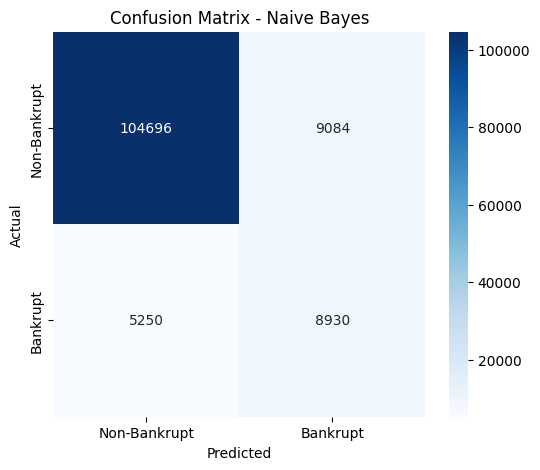

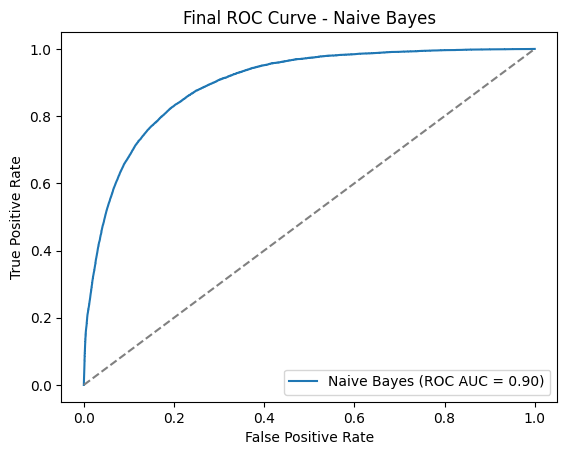

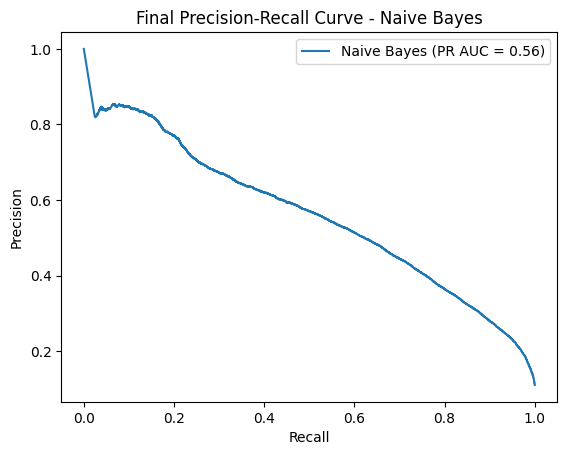

In [16]:



for model_name, model in models.items():
    print(f"Training {model_name} with Cross-Validation")
    thresholds = []

    for fold_idx, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train.values[train_index], y_train.values[val_index]

        model.fit(X_fold_train, y_fold_train)


        y_fold_proba = cp.asnumpy(model.predict_proba(X_fold_val))[:, 1]

        best_threshold = 0.5
        best_f1 = 0

        for threshold in np.arange(0.1, 1.0, 0.01):
            y_fold_pred = (y_fold_proba >= threshold).astype(int)
            f1 = f1_score(y_fold_val, y_fold_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        thresholds.append(best_threshold)

        y_fold_pred = (y_fold_proba >= best_threshold).astype(int)


        # Metrics
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        precision = precision_score(y_fold_val, y_fold_pred)
        recall = recall_score(y_fold_val, y_fold_pred)
        f1 = f1_score(y_fold_val, y_fold_pred)
        roc_auc = roc_auc_score(y_fold_val, y_fold_proba)

        conf_matrix = confusion_matrix(y_fold_val, y_fold_pred)
        class_acc = {
            "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
            "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
        }
        pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_fold_val, y_fold_proba)
        pr_auc = auc(pr_curve_recall, pr_curve_precision)

        cv_results[model_name].append({
            "Fold": fold_idx + 1,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc,
            "Class Accuracies": class_acc
        })

        #curves
        fpr, tpr, _ = roc_curve(y_fold_val, y_fold_proba)
        roc_curves_cv[model_name].append((fpr, tpr))
        pr_curves_cv[model_name].append((pr_curve_precision, pr_curve_recall))

    #mean threshold
    mean_threshold = np.mean(thresholds)
    print(f"Mean Threshold for {model_name}: {mean_threshold:.2f}")

# Display Cross-validation Metrics
for model_name in models.keys():
    print(f"\nCross-validation Metrics for {model_name}:")
    for fold_metrics in cv_results[model_name]:
        print(f"  Fold {fold_metrics['Fold']}:")
        for metric, value in fold_metrics.items():
            if metric != "Fold" and metric != "Class Accuracies":
                print(f"    {metric}: {value:.4f}")
        print(f"    Class Accuracies: {fold_metrics['Class Accuracies']}")

    # Plot cross-validation ROC and PR curves
    plt.figure()
    for fold_idx, (fpr, tpr) in enumerate(roc_curves_cv[model_name]):
        plt.plot(fpr, tpr, label=f"Fold {fold_idx + 1}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
    plt.title(f"Cross-validation ROC Curves - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure()
    for fold_idx, (precision, recall) in enumerate(pr_curves_cv[model_name]):
        plt.plot(recall, precision, label=f"Fold {fold_idx + 1}")
    plt.title(f"Cross-validation Precision-Recall Curves - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Final Model Training and Evaluation
final_results = {}
roc_curves_final = {}
pr_curves_final = {}

for model_name, model in models.items():
    print(f"\nFinal Training for {model_name}")
    model.fit(X_train, y_train)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Use the mean threshold from CV
    mean_threshold = np.mean(thresholds)
    y_test_pred = (y_test_proba >= mean_threshold).astype(int)

    # Metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_acc = {
        "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
        "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
    }
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_test, y_test_proba)
    pr_auc = auc(pr_curve_recall, pr_curve_precision)

    # Save results
    final_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Class Accuracies": class_acc
    }

    # Display final metrics
    print(f"\nFinal Metrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print(f"  Class Accuracies: {class_acc}")

     # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Bankrupt', 'Bankrupt'],
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save final curves
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_curves_final[model_name] = (fpr, tpr)
    pr_curves_final[model_name] = (pr_curve_precision, pr_curve_recall)

    # Plot final curves
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"Final ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(pr_curve_recall, pr_curve_precision, label=f"{model_name} (PR AUC = {pr_auc:.2f})")
    plt.title(f"Final Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()






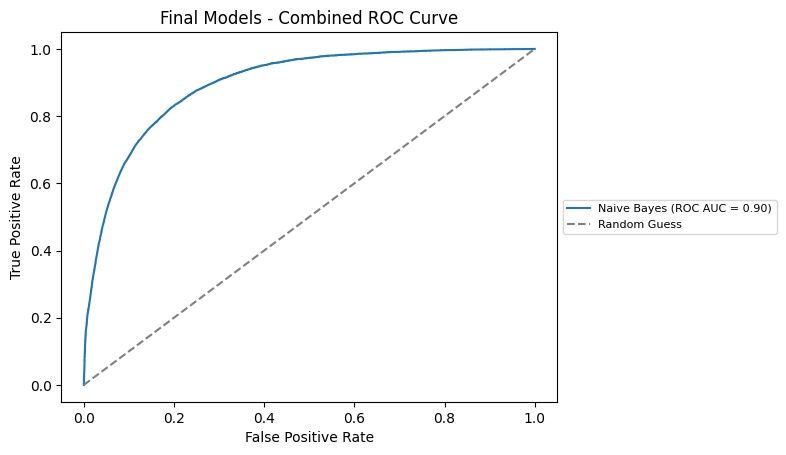

In [17]:
# Combined ROC Curve for Final Models
plt.figure()
for model_name, (fpr, tpr) in roc_curves_final.items():
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {final_results[model_name]['ROC AUC']:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("Final Models - Combined ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#Saving fit models

Saving

In [18]:
import joblib
import os
os.makedirs("saved_models", exist_ok=True)
for model_name, model in models.items():
    model_path = f"/content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/{model_name}.pkl"
    joblib.dump(model, model_path)



In [19]:
import os
loaded_models = {}
for model_name in models.keys():
    model_path = f"/content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/{model_name}.pkl"
    if os.path.exists(model_path):
        loaded_models[model_name] = joblib.load(model_path)
        print(f"{model_name} loaded from {model_path}.")
    else:
        print(f"{model_name} not found in {model_path}, please train the model.")


Naive Bayes loaded from /content/drive/MyDrive/Bankruptcy Prediction Data/SCRIPTS/Saved fit models/Naive Bayes.pkl.


#Loading results saved

In [20]:
'''from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Re-evaluate saved models
final_results = {}
pr_curves_final = {}
roc_curves_final = {}
for model_name, model in loaded_models.items():
    print(f"\nEvaluating {model_name} on Test Data")

    y_test_proba = model.predict_proba(X_test)[:, 1]  # Assuming predict_proba is available
    y_test_pred = (y_test_proba >= 0.5).astype(int)  # Default threshold 0.5

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    conf_matrix = confusion_matrix(y_test, y_test_pred)
    class_acc = {
        "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum(),
        "bankrupt": conf_matrix[1, 1] / conf_matrix[1].sum()
    }
    pr_curve_precision, pr_curve_recall, _ = precision_recall_curve(y_test, y_test_proba)
    pr_auc = auc(pr_curve_recall, pr_curve_precision)

    # Store results
    final_results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Class Accuracies": class_acc
    }

    # Display metrics
    print(f"\nMetrics for {model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  PR AUC: {pr_auc:.4f}")
    print(f"  Class Accuracies: {class_acc}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Bankrupt', 'Bankrupt'],
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Plot PR Curve
    plt.figure()
    plt.plot(pr_curve_recall, pr_curve_precision, label=f"{model_name} (PR AUC = {pr_auc:.2f})")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
'''

'from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve, auc\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Re-evaluate saved models\nfinal_results = {}\npr_curves_final = {}\nroc_curves_final = {}\nfor model_name, model in loaded_models.items():\n    print(f"\nEvaluating {model_name} on Test Data")\n\n    y_test_proba = model.predict_proba(X_test)[:, 1]  # Assuming predict_proba is available\n    y_test_pred = (y_test_proba >= 0.5).astype(int)  # Default threshold 0.5\n\n    # Calculate metrics\n    accuracy = accuracy_score(y_test, y_test_pred)\n    precision = precision_score(y_test, y_test_pred)\n    recall = recall_score(y_test, y_test_pred)\n    f1 = f1_score(y_test, y_test_pred)\n    roc_auc = roc_auc_score(y_test, y_test_proba)\n\n    conf_matrix = confusion_matrix(y_test, y_test_pred)\n    class_acc = {\n        "non_bankrupt": conf_matrix[0, 0] / conf_matrix[0].sum()

#Feature Importance

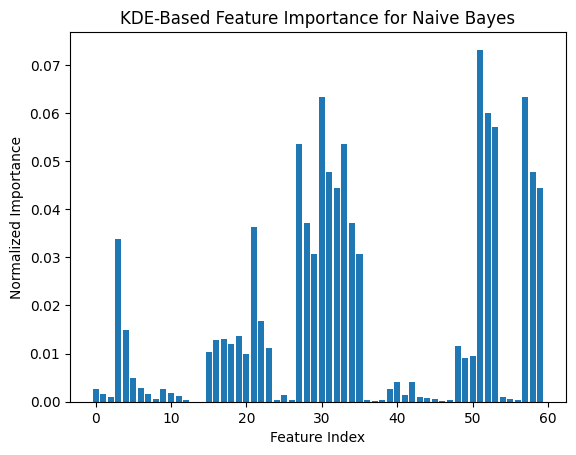

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_kde_feature_importance(model, X):
    """
    Calculate feature importance based on KDE log-likelihoods for Naive Bayes KDE.

    Parameters:
        model: Fitted NaiveBayesKDE model.
        X: Feature matrix (NumPy array).

    Returns:
        feature_importances: Array of feature importances.
    """
    feature_importances = []

    for feature_idx in range(X.shape[1]):
        # Calculate log-likelihood for each class for the feature
        log_likelihoods = []
        for label in model.classes_:
            kde = model.kde_models[label][feature_idx]
            feature_column = cp.array(X[:, feature_idx].reshape(-1, 1))
            log_likelihood = cp.sum(kde.score_samples(feature_column))
            log_likelihoods.append(cp.asnumpy(log_likelihood))

        # Feature importance as the absolute difference in log-likelihoods
        importance = abs(log_likelihoods[1] - log_likelihoods[0])
        feature_importances.append(importance)

    return np.array(feature_importances)

# Compute feature importance
kde_feature_importances = calculate_kde_feature_importance(models["Naive Bayes"], X_test)

# Normalize and plot
normalized_importance = kde_feature_importances / np.sum(kde_feature_importances)
plt.bar(range(len(normalized_importance)), normalized_importance)
plt.xlabel("Feature Index")
plt.ylabel("Normalized Importance")
plt.title("KDE-Based Feature Importance for Naive Bayes")
plt.show()


In [28]:
feature_names = X.columns  # Assuming X is a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": normalized_importance
})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
print(importance_df)


                                              Feature  Importance
51  Liquidity Ratios (Current Liabilities − Cash)/...    0.073158
30       Trade Debts/Total Assets last available year    0.063402
57  Current Liabilities/Total Assets last availabl...    0.063402
52  Liquidity Ratios (Current Liabilities − Cash)/...    0.060081
53  Liquidity Ratios (Current Liabilities − Cash)/...    0.057101
27  Solvency Ratios Total Liabilities/Total Assets...    0.053469
33            Equity/Total Assets last available year    0.053469
31              Trade Debts/Total Assets last year -1    0.047778
58      Current Liabilities/Total Assets last year -1    0.047778
32              Trade Debts/Total Assets last year -2    0.044335
59      Current Liabilities/Total Assets last year -2    0.044335
28  Solvency Ratios Total Liabilities/Total Assets...    0.037174
34                   Equity/Total Assets last year -1    0.037174
21  net working capital/total assets last avail. Year    0.036264
3   Profit